<a href="https://colab.research.google.com/github/kumar-abhishek/imbalanced-machine-learning-book/blob/main/chapter-7/Cutmix_mixup_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running a default CNN model on Fashion MNIST dataset to benchmark it's accuracy


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import time
import torchvision
import random
import copy
import cv2
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data.sampler import  SubsetRandomSampler
seed = 44
random.seed(seed)
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        return x

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def train(train_dataloader, valid_dataloader, PATH, model = None, criterion= F.cross_entropy, epochs=1):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    model.train()
    best_acc = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        losses = 0.0
        for b_i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss = criterion(pred_prob, y) # nll is the negative likelihood loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += loss.item()
            if b_i % 10 == 0:
                print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                    epoch, b_i, len(train_dataloader),
                    100. * b_i / len(train_dataloader), loss.item()))

        train_losses.append(losses/len(train_dataloader))

        print("\n")
        print("Validation...")
        model.eval()
        loss = 0
        success = 0
        with torch.no_grad():
            for X, y in valid_dataloader:
                X, y = X.to(device), y.to(device)
                pred_prob = model(X)
                loss += criterion(pred_prob, y, reduction='sum').item()  # loss summed across the batch
                pred = pred_prob.argmax(dim=1, keepdim=True)  # use argmax to get the most likely prediction
                success += pred.eq(y.view_as(pred)).sum().item()

        loss /= len(valid_dataloader.dataset)

        val_losses.append(loss)

        accuracy = 100. * success / len(valid_dataloader.dataset)

        if (accuracy > best_acc):
          torch.save(model.state_dict(), PATH)
          best_acc = accuracy

        print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
            loss, success, len(valid_dataloader.dataset), accuracy))
    return model, train_losses, val_losses

def test(model, PATH, criterion = F.cross_entropy):
    model.eval()
    model.load_state_dict(torch.load(PATH))
    loss = 0
    success = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += criterion(pred_prob, y).item()  # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)  # use argmax to get the most likely prediction
            correct = np.squeeze(pred.eq(y.view_as(pred)))
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    accuracy = 100. * success / len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset), accuracy))

    for i in range(len(y)):
          label = y[i]
          class_correct[label] += correct[i].item()
          class_total[label] +=1
    class_percentages = []
    for i in range(len(class_correct)):
        class_percentages.append(class_correct[i] / class_total[i])

    return accuracy, class_percentages

## Orignal Fashion Mnist Dataset Class distribution

100%|██████████| 26421880/26421880 [00:02<00:00, 9901768.67it/s] 


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 180541.65it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3225553.13it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18283045.72it/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})
Distribution of classes in original dataset:


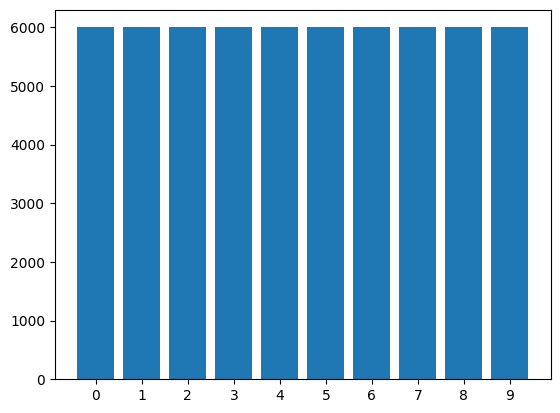

In [5]:
trainset = datasets.FashionMNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1302,), (0.3069,))]))
print(Counter(trainset.targets.numpy()))

print('Distribution of classes in original dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(trainset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

#Preparing for validaion test
indices = list(range(len(trainset)))
np.random.seed(seed)
np.random.shuffle(indices)
#to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

#Data Loader
train_dataloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
valid_dataloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)

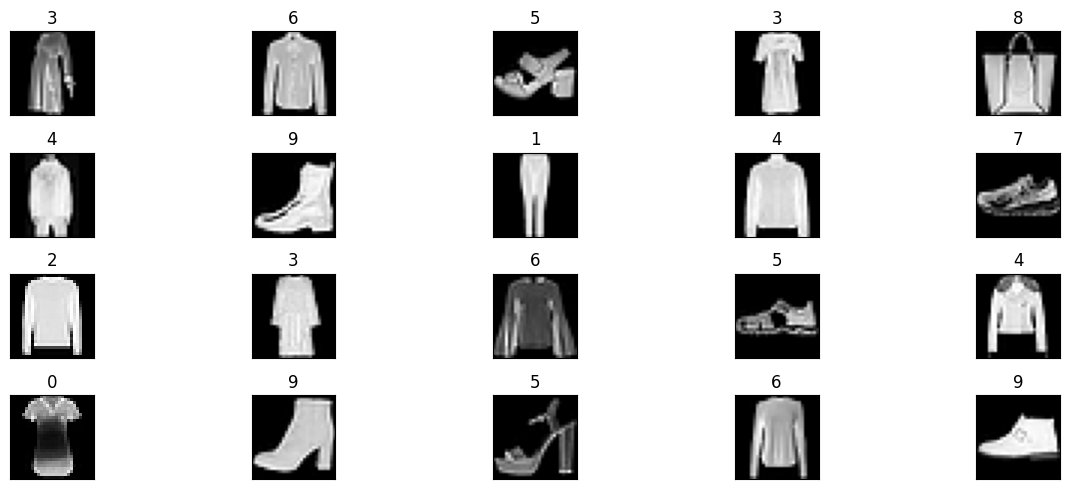

In [6]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)


fig = plt.figure(figsize=(15,5))
for idx in np.arange(20):
  # xticks=[], yticks=[] is empty to print the images without any ticks around them
  #np.sqeeze : Remove single-dimensional entries from the shape of an array.
  ax = fig.add_subplot(4, int(20/4), idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
   # .item() gets the value contained in a Tensor
  ax.set_title(labels[idx].item())
  fig.tight_layout()

In [7]:
test_ds = datasets.FashionMNIST('../data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))]))

test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=500, shuffle=True)

# Balanced/Orignal Dataset Training

In [8]:
model, train_losses, val_losses = train(train_dataloader, valid_dataloader, "Balanced_model.pth",  ConvNet().to(device), epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 0 [0/188 (0%)]	 training loss: 2.290501
epoch: 0 [10/188 (5%)]	 training loss: 1.811283
epoch: 0 [20/188 (11%)]	 training loss: 1.171675
epoch: 0 [30/188 (16%)]	 training loss: 0.867387
epoch: 0 [40/188 (21%)]	 training loss: 0.817765
epoch: 0 [50/188 (27%)]	 training loss: 0.825418
epoch: 0 [60/188 (32%)]	 training loss: 0.824552
epoch: 0 [70/188 (37%)]	 training loss: 0.583640
epoch: 0 [80/188 (43%)]	 training loss: 0.833187
epoch: 0 [90/188 (48%)]	 training loss: 0.749746
epoch: 0 [100/188 (53%)]	 training loss: 0.691127
epoch: 0 [110/188 (59%)]	 training loss: 0.558354
epoch: 0 [120/188 (64%)]	 training loss: 0.548295
epoch: 0 [130/188 (69%)]	 training loss: 0.758621
epoch: 0 [140/188 (74%)]	 training loss: 0.695426
epoch: 0 [150/188 (80%)]	 training loss: 0.688806
epoch: 0 [160/188 (85%)]	 training loss: 0.822026
epoch: 0 [170/188 (90%)]	 training loss: 0.647707
epoch: 0 [180/188 (96%)]	 training loss: 0.656371


Validation...

Test dataset: Overall Loss: 0.4446, Overall Ac

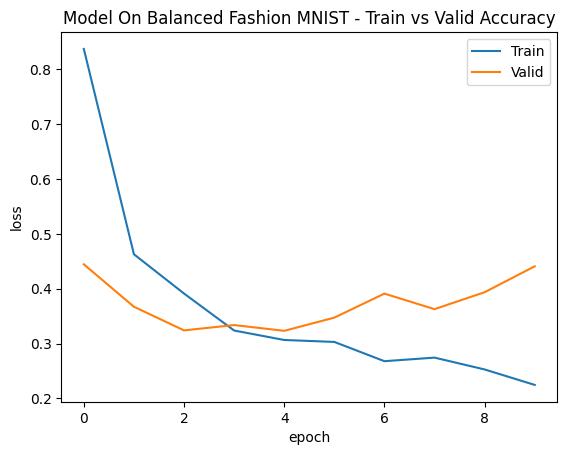

In [9]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Model On Balanced Fashion MNIST - Train vs Valid Accuracy')

plt.show()

# Test Model

In [10]:
print("On vanilla Fashion MNIST dataset")
test_acc, _ = test(model,  "Balanced_model.pth")
print("test accuracy : ", str(test_acc))

On vanilla Fashion MNIST dataset

Test dataset: Overall Loss: 0.0009, Overall Accuracy: 8540/10000 (85%)

test accuracy :  85.4


# Performance of the Model on Imbalanced MNIST Dataset

### Create Imbalanced Dataset

Distribution of classes in Imbalanced dataset:
Counter({8: 5901, 9: 5202, 2: 4912, 5: 4346, 1: 4333, 0: 4318, 4: 3739, 6: 1712, 7: 1308, 3: 799})


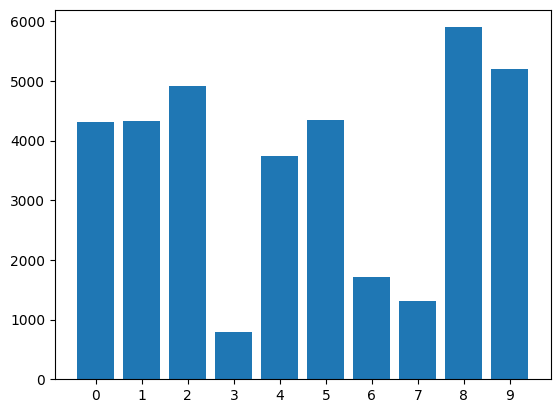

In [11]:
trainset = datasets.FashionMNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1302,), (0.3069,))]))

# generate imbalanced dataset
num_classes = 10
torch.manual_seed(seed)
sample_probs = torch.rand(num_classes)

idx_to_remove = [idx for idx, target in enumerate(train_dataloader.dataset.targets)
              if random.random() > sample_probs[target] #or target in range(3, 10)
              ]
imbalanced_train_dataset = copy.deepcopy(trainset)
imbalanced_train_dataset.targets = np.delete(trainset.targets, idx_to_remove, axis=0)
imbalanced_train_dataset.data = np.delete(trainset.data,
                                            idx_to_remove, axis=0)
print('Distribution of classes in Imbalanced dataset:')
print(Counter(imbalanced_train_dataset.targets.numpy()))
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_dataset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

#Preparing for validaion test
indices = list(range(len(imbalanced_train_dataset)))
np.random.seed(seed)
np.random.shuffle(indices)
#to get 20% of the train set
split = int(np.floor(0.2 * len(imbalanced_train_dataset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

#Data Loader
imbalanced_train_loader = torch.utils.data.DataLoader(imbalanced_train_dataset, sampler=train_sample, batch_size=64)
imbalanced_valid_loader = torch.utils.data.DataLoader(imbalanced_train_dataset, sampler=valid_sample, batch_size=64)

### train model on imbalanced dataset

In [12]:
imbalanced_model, train_losses, val_losses = train(imbalanced_train_loader, imbalanced_valid_loader,  "Imbalanced_model.pth", ConvNet().to(device), epochs=30)

epoch: 0 [0/115 (0%)]	 training loss: 2.325553
epoch: 0 [10/115 (9%)]	 training loss: 1.479495
epoch: 0 [20/115 (17%)]	 training loss: 1.006495
epoch: 0 [30/115 (26%)]	 training loss: 0.755933
epoch: 0 [40/115 (35%)]	 training loss: 0.761454
epoch: 0 [50/115 (43%)]	 training loss: 1.074961
epoch: 0 [60/115 (52%)]	 training loss: 1.049627
epoch: 0 [70/115 (61%)]	 training loss: 0.680482
epoch: 0 [80/115 (70%)]	 training loss: 0.698637
epoch: 0 [90/115 (78%)]	 training loss: 0.701401
epoch: 0 [100/115 (87%)]	 training loss: 0.684192
epoch: 0 [110/115 (96%)]	 training loss: 0.369228


Validation...

Test dataset: Overall Loss: 0.4011, Overall Accuracy: 24163/36570 (66%)

epoch: 1 [0/115 (0%)]	 training loss: 0.469329
epoch: 1 [10/115 (9%)]	 training loss: 0.772765
epoch: 1 [20/115 (17%)]	 training loss: 0.586373
epoch: 1 [30/115 (26%)]	 training loss: 0.213761
epoch: 1 [40/115 (35%)]	 training loss: 0.672396
epoch: 1 [50/115 (43%)]	 training loss: 0.480285
epoch: 1 [60/115 (52%)]	 trainin

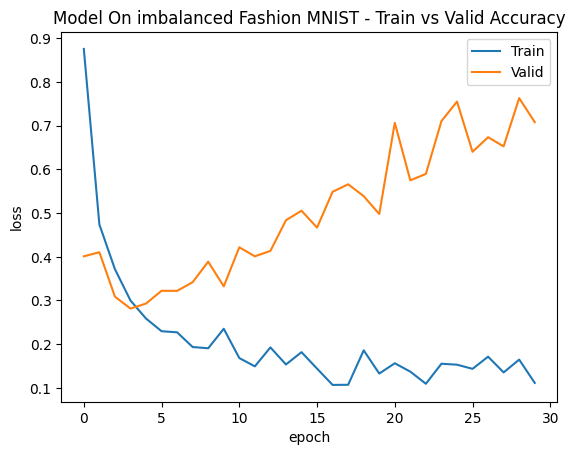

In [13]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Model On imbalanced Fashion MNIST - Train vs Valid Accuracy')

plt.show()

### test on test set

In [14]:
print("On imbalanced MNIST dataset")
test_acc1, class_percentages1 = test(imbalanced_model, "Imbalanced_model.pth")
print("test accuracy : ", str(test_acc1))

On imbalanced MNIST dataset

Test dataset: Overall Loss: 0.0010, Overall Accuracy: 8346/10000 (83%)

test accuracy :  83.46


## Cutmix Image Augmentation

In [15]:
# Adapted from https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py

def rand_bbox(size, lam):
    """

    :param size: torch.Size. Shape:(batch_size, channel, image_size, image_size)
    :param lam: cutmix rate
    :return: box boundary
    """
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets, alpha):
    """

    :param data: torch.Size. Shape:(batch_size, channel, image_size, image_size)
    :param targets: torch.Tensor. multitask, multi-classification, target1. shape(batch_size, 1)
    :param alpha: float, positive
    :return: resulting image, multi-target
    """
    indices = torch.randperm(data.size(0))
    # shuffled_data = data[indices]
    targets_a = targets
    targets_b = targets[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets_a, targets_b, lam]
    return data, targets

In [16]:
def train_cut_mix(train_dataloader, valid_dataloader, PATH, model = None, criterion= F.cross_entropy, epochs=1):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    model.train()
    best_acc = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        losses = 0.0
        for b_i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            X, ys = cutmix(X, y, alpha=0.75)
            pred_prob = model(X)
            targets1, targets2, lam = ys[0], ys[1], ys[2]
            loss = lam * criterion(pred_prob, targets1) + (1 - lam) * criterion(pred_prob, targets2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += loss.item()
            if b_i % 10 == 0:
                print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                    epoch, b_i, len(train_dataloader),
                    100. * b_i / len(train_dataloader), loss.item()))

        train_losses.append(losses/len(train_dataloader))

        print("\n")
        print("Validation...")
        model.eval()
        loss = 0
        success = 0
        with torch.no_grad():
            for X, y in valid_dataloader:
                X, y = X.to(device), y.to(device)
                pred_prob = model(X)
                loss += criterion(pred_prob, y, reduction='sum').item()  # loss summed across the batch
                pred = pred_prob.argmax(dim=1, keepdim=True)  # use argmax to get the most likely prediction
                success += pred.eq(y.view_as(pred)).sum().item()

        loss /= len(valid_dataloader.dataset)

        val_losses.append(loss)

        accuracy = 100. * success / len(valid_dataloader.dataset)

        if (accuracy > best_acc):
          torch.save(model.state_dict(), PATH)
          best_acc = accuracy

        print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
            loss, success, len(valid_dataloader.dataset), accuracy))
    return model, train_losses, val_losses

In [17]:
imbalanced_model_cutmix, train_losses, val_losses = train_cut_mix(imbalanced_train_loader, imbalanced_valid_loader, "imbalanced_model_cutmix.pth", ConvNet().to(device), epochs=30)

epoch: 0 [0/115 (0%)]	 training loss: 2.300316
epoch: 0 [10/115 (9%)]	 training loss: 1.753518
epoch: 0 [20/115 (17%)]	 training loss: 1.702334
epoch: 0 [30/115 (26%)]	 training loss: 1.861643
epoch: 0 [40/115 (35%)]	 training loss: 1.792369
epoch: 0 [50/115 (43%)]	 training loss: 1.633794
epoch: 0 [60/115 (52%)]	 training loss: 1.258573
epoch: 0 [70/115 (61%)]	 training loss: 1.464284
epoch: 0 [80/115 (70%)]	 training loss: 1.196486
epoch: 0 [90/115 (78%)]	 training loss: 1.665556
epoch: 0 [100/115 (87%)]	 training loss: 1.587716
epoch: 0 [110/115 (96%)]	 training loss: 1.274816


Validation...

Test dataset: Overall Loss: 0.5867, Overall Accuracy: 23124/36570 (63%)

epoch: 1 [0/115 (0%)]	 training loss: 1.572726
epoch: 1 [10/115 (9%)]	 training loss: 1.525487
epoch: 1 [20/115 (17%)]	 training loss: 1.291394
epoch: 1 [30/115 (26%)]	 training loss: 0.896748
epoch: 1 [40/115 (35%)]	 training loss: 0.608567
epoch: 1 [50/115 (43%)]	 training loss: 0.944040
epoch: 1 [60/115 (52%)]	 trainin

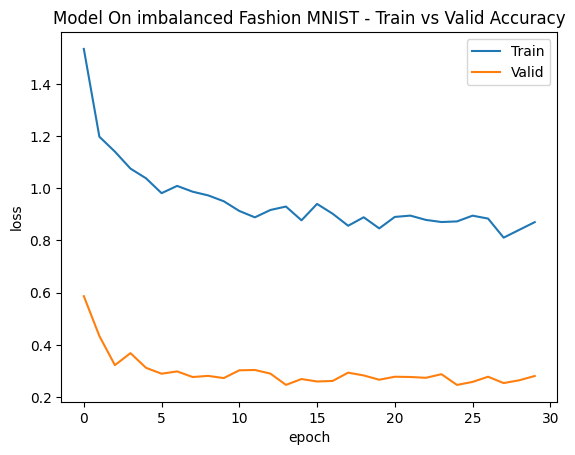

In [18]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Model On imbalanced Fashion MNIST - Train vs Valid Accuracy')

plt.show()

In [19]:
print("On Imbalanced Fashion MNIST dataset")
test_acc2, class_percentages2 = test(imbalanced_model_cutmix, "imbalanced_model_cutmix.pth")
print("test accuracy : ", str(test_acc2))

On Imbalanced Fashion MNIST dataset

Test dataset: Overall Loss: 0.0009, Overall Accuracy: 8513/10000 (85%)

test accuracy :  85.13


## MixUp


In [20]:
def mixup(data, targets, alpha):
    """

        :param data: torch.Size. Shape:(batch_size, channel, image_size, image_size)
        :param targets: torch.Tensor. multitask, multi-classification, target1. shape(batch_size, 1)
        :param alpha: float, positive
        :return: resulting image, multi-target
        """
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets, shuffled_targets, lam]

    return data, targets

In [21]:
def train_mixup(train_dataloader, valid_dataloader, PATH, model = None, criterion= F.cross_entropy, epochs=1):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    model.train()
    best_acc = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        losses = 0.0
        for b_i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            X, ys = mixup(X, y, alpha=0.5)
            pred_prob = model(X)
            targets1, targets2, lam = ys[0], ys[1], ys[2]
            loss = lam * criterion(pred_prob, targets1) + (1 - lam) * criterion(pred_prob, targets2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += loss.item()
            if b_i % 10 == 0:
                print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                    epoch, b_i, len(train_dataloader),
                    100. * b_i / len(train_dataloader), loss.item()))

        train_losses.append(losses/len(train_dataloader))

        print("\n")
        print("Validation...")
        model.eval()
        loss = 0
        success = 0
        with torch.no_grad():
            for X, y in valid_dataloader:
                X, y = X.to(device), y.to(device)
                pred_prob = model(X)
                loss += criterion(pred_prob, y, reduction='sum').item()  # loss summed across the batch
                pred = pred_prob.argmax(dim=1, keepdim=True)  # use argmax to get the most likely prediction
                success += pred.eq(y.view_as(pred)).sum().item()

        loss /= len(valid_dataloader.dataset)

        val_losses.append(loss)

        accuracy = 100. * success / len(valid_dataloader.dataset)

        if (accuracy > best_acc):
          torch.save(model.state_dict(), PATH)
          best_acc = accuracy

        print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
            loss, success, len(valid_dataloader.dataset), accuracy))
    return model, train_losses, val_losses

In [22]:
imbalanced_model_mixup, train_losses, val_losses = train_mixup(imbalanced_train_loader, imbalanced_valid_loader, "imbalanced_model_mixup.pth", ConvNet().to(device), epochs=30)

epoch: 0 [0/115 (0%)]	 training loss: 2.294178
epoch: 0 [10/115 (9%)]	 training loss: 1.920017
epoch: 0 [20/115 (17%)]	 training loss: 1.745983
epoch: 0 [30/115 (26%)]	 training loss: 0.968593
epoch: 0 [40/115 (35%)]	 training loss: 0.862124
epoch: 0 [50/115 (43%)]	 training loss: 1.142517
epoch: 0 [60/115 (52%)]	 training loss: 1.406391
epoch: 0 [70/115 (61%)]	 training loss: 1.734415
epoch: 0 [80/115 (70%)]	 training loss: 0.824118
epoch: 0 [90/115 (78%)]	 training loss: 1.407597
epoch: 0 [100/115 (87%)]	 training loss: 0.792803
epoch: 0 [110/115 (96%)]	 training loss: 0.575507


Validation...

Test dataset: Overall Loss: 0.4235, Overall Accuracy: 24499/36570 (67%)

epoch: 1 [0/115 (0%)]	 training loss: 1.075696
epoch: 1 [10/115 (9%)]	 training loss: 0.815046
epoch: 1 [20/115 (17%)]	 training loss: 1.607873
epoch: 1 [30/115 (26%)]	 training loss: 0.959486
epoch: 1 [40/115 (35%)]	 training loss: 0.658086
epoch: 1 [50/115 (43%)]	 training loss: 0.671186
epoch: 1 [60/115 (52%)]	 trainin

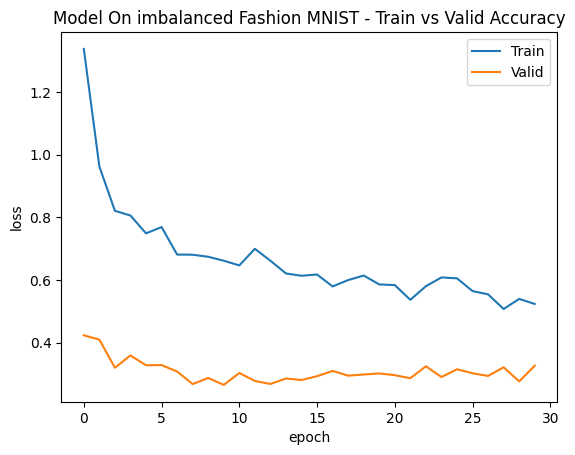

In [23]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Model On imbalanced Fashion MNIST - Train vs Valid Accuracy')

plt.show()

In [24]:
print("On Imbalanced Fashion MNIST dataset")
test_acc3, class_percentages3 = test(imbalanced_model_mixup, "imbalanced_model_mixup.pth")
print("Mixup test accuracy : ", str(test_acc3))

On Imbalanced Fashion MNIST dataset

Test dataset: Overall Loss: 0.0011, Overall Accuracy: 8494/10000 (85%)

Mixup test accuracy :  84.94


# Cutmix + Mixup

In [25]:
def train_cutmix_mixup(train_dataloader, valid_dataloader, PATH, model = None, criterion= F.cross_entropy, epochs=1):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    model.train()
    best_acc = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        losses = 0.0
        for b_i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            mix_decision = np.random.rand()
            if mix_decision < 0.5:
               X, ys = mixup(X, y, alpha=0.5)
            if mix_decision >= 0.5:
               X, ys = cutmix(X, y, alpha=0.5)
            pred_prob = model(X)
            targets1, targets2, lam = ys[0], ys[1], ys[2]
            loss = lam * criterion(pred_prob, targets1) + (1 - lam) * criterion(pred_prob, targets2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += loss.item()
            if b_i % 10 == 0:
                print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                    epoch, b_i, len(train_dataloader),
                    100. * b_i / len(train_dataloader), loss.item()))

        train_losses.append(losses/len(train_dataloader))

        print("\n")
        print("Validation...")
        model.eval()
        loss = 0
        success = 0
        with torch.no_grad():
            for X, y in valid_dataloader:
                X, y = X.to(device), y.to(device)
                pred_prob = model(X)
                loss += criterion(pred_prob, y, reduction='sum').item()  # loss summed across the batch
                pred = pred_prob.argmax(dim=1, keepdim=True)  # use argmax to get the most likely prediction
                success += pred.eq(y.view_as(pred)).sum().item()

        loss /= len(valid_dataloader.dataset)

        val_losses.append(loss)

        accuracy = 100. * success / len(valid_dataloader.dataset)

        if (accuracy > best_acc):
          torch.save(model.state_dict(), PATH)
          best_acc = accuracy

        print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
            loss, success, len(valid_dataloader.dataset), accuracy))
    return model, train_losses, val_losses

In [26]:
imbalanced_model_cutmix_mixup, train_losses, val_losses = train_mixup(imbalanced_train_loader, imbalanced_valid_loader, "imbalanced_model_cutmix_mixup.pth", ConvNet().to(device), epochs=30)

epoch: 0 [0/115 (0%)]	 training loss: 2.307527
epoch: 0 [10/115 (9%)]	 training loss: 1.425300
epoch: 0 [20/115 (17%)]	 training loss: 1.952033
epoch: 0 [30/115 (26%)]	 training loss: 0.926028
epoch: 0 [40/115 (35%)]	 training loss: 0.837403
epoch: 0 [50/115 (43%)]	 training loss: 1.051845
epoch: 0 [60/115 (52%)]	 training loss: 0.749171
epoch: 0 [70/115 (61%)]	 training loss: 1.296326
epoch: 0 [80/115 (70%)]	 training loss: 0.561196
epoch: 0 [90/115 (78%)]	 training loss: 0.548862
epoch: 0 [100/115 (87%)]	 training loss: 1.779808
epoch: 0 [110/115 (96%)]	 training loss: 0.650787


Validation...

Test dataset: Overall Loss: 0.4905, Overall Accuracy: 23267/36570 (64%)

epoch: 1 [0/115 (0%)]	 training loss: 1.506715
epoch: 1 [10/115 (9%)]	 training loss: 0.968435
epoch: 1 [20/115 (17%)]	 training loss: 0.509103
epoch: 1 [30/115 (26%)]	 training loss: 1.168047
epoch: 1 [40/115 (35%)]	 training loss: 0.905132
epoch: 1 [50/115 (43%)]	 training loss: 1.115544
epoch: 1 [60/115 (52%)]	 trainin

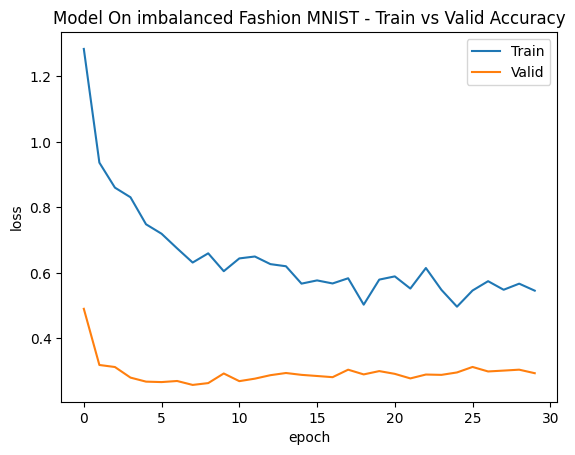

In [27]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Model On imbalanced Fashion MNIST - Train vs Valid Accuracy')

plt.show()

In [28]:
print("On Imbalanced Fashion MNIST dataset")
test_acc4, class_percentages4 = test(imbalanced_model_cutmix_mixup, "imbalanced_model_cutmix_mixup.pth")
print("Cutmix+Mixup test accuracy : ", str(test_acc4))

On Imbalanced Fashion MNIST dataset

Test dataset: Overall Loss: 0.0011, Overall Accuracy: 8433/10000 (84%)

Cutmix+Mixup test accuracy :  84.33


# ReMix

In [29]:
Counter(imbalanced_train_dataset.targets.numpy())

Counter({9: 5202,
         0: 4318,
         2: 4912,
         7: 1308,
         5: 4346,
         1: 4333,
         4: 3739,
         3: 799,
         8: 5901,
         6: 1712})

In [30]:
def remix_data(inputs, labels, class_counts, alpha=1.0):
    '''
    Returns mixed inputs, pairs of targets, and lambda_x, lambda_y
    '''
    if alpha > 0:
        lambda_x = np.random.beta(alpha, alpha)
    else:
        lambda_x = 1

    K = 3  # hyperparameter for majority class
    tau = 0.5  # hyperparameter

    class_counts_tensor = torch.tensor(class_counts)
    batch_size = inputs.size()[0]
    random_indices = torch.randperm(batch_size)

    class_count_pairs = [
        [class_counts_tensor[labels[i]].item(), class_counts_tensor[labels[j]].item()]
        for i, j in enumerate(random_indices)
    ]
    class_count_pairs = torch.tensor(class_count_pairs)

    lambda_y_values = []
    for pair in class_count_pairs:
        class_count_ratio = pair[0] / pair[1]

        if class_count_ratio >= K and lambda_x < tau:
            lambda_y_values.append(0)
        elif class_count_ratio <= (1 / K) and (1 - lambda_x) < tau:
            lambda_y_values.append(1)
        else:
            lambda_y_values.append(lambda_x)

    lambda_y = torch.tensor(lambda_y_values).cuda(0)
    mixed_inputs = lambda_x * inputs + (1 - lambda_x) * inputs[random_indices, :]
    labels_a, labels_b = labels, labels[random_indices]

    return mixed_inputs, [labels_a, labels_b, lambda_y]


In [31]:
def remix_criterion(criterion, pred, y_a, y_b, lam_y):
    """
    In Remix, the lambda for mixing label is different from original mixup.
    """
    # for each y, we calculated its loss individually with their respective
    # lambda_y
    loss = torch.mul(criterion(pred, y_a), lam_y) + \
                    torch.mul(criterion(pred, y_b), (1 - lam_y))
    return loss.mean()


def train_remix(cls_num_list, train_dataloader, valid_dataloader, PATH, model = None, criterion= F.cross_entropy, epochs=1):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    model.train()
    best_acc = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        losses = 0.0
        for b_i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            X, ys = remix_data(X, y, cls_num_list, alpha=0.5)
            pred_prob = model(X)
            targets1, targets2, lam = ys[0], ys[1], ys[2]
            loss = remix_criterion(criterion, pred_prob, targets1, targets2, lam)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += loss.item()
            if b_i % 10 == 0:
                print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                    epoch, b_i, len(train_dataloader),
                    100. * b_i / len(train_dataloader), loss.item()))

        train_losses.append(losses/len(train_dataloader))

        print("\n")
        print("Validation...")
        model.eval()
        loss = 0
        success = 0
        with torch.no_grad():
            for X, y in valid_dataloader:
                X, y = X.to(device), y.to(device)
                pred_prob = model(X)
                loss += criterion(pred_prob, y, reduction='sum').item()  # loss summed across the batch
                pred = pred_prob.argmax(dim=1, keepdim=True)  # use argmax to get the most likely prediction
                success += pred.eq(y.view_as(pred)).sum().item()

        loss /= len(valid_dataloader.dataset)

        val_losses.append(loss)

        accuracy = 100. * success / len(valid_dataloader.dataset)

        if (accuracy > best_acc):
          torch.save(model.state_dict(), PATH)
          best_acc = accuracy

        print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
            loss, success, len(valid_dataloader.dataset), accuracy))
    return model, train_losses, val_losses

In [32]:
per_class_count_dict = dict(Counter(imbalanced_train_dataset.targets.numpy()))
cls_num_list = []
for i in range(10):
  cls_num_list.append(per_class_count_dict[i])
print(cls_num_list)

[4318, 4333, 4912, 799, 3739, 4346, 1712, 1308, 5901, 5202]


In [33]:
imbalanced_model_remix, train_losses, val_losses = train_remix(cls_num_list, imbalanced_train_loader, imbalanced_valid_loader, "imbalanced_model_remix.pth", ConvNet().to(device), epochs=30)

epoch: 0 [0/115 (0%)]	 training loss: 2.343318
epoch: 0 [10/115 (9%)]	 training loss: 1.895211
epoch: 0 [20/115 (17%)]	 training loss: 1.279674
epoch: 0 [30/115 (26%)]	 training loss: 1.039187
epoch: 0 [40/115 (35%)]	 training loss: 1.327869
epoch: 0 [50/115 (43%)]	 training loss: 0.912365
epoch: 0 [60/115 (52%)]	 training loss: 1.590173
epoch: 0 [70/115 (61%)]	 training loss: 1.643829
epoch: 0 [80/115 (70%)]	 training loss: 1.090404
epoch: 0 [90/115 (78%)]	 training loss: 0.665247
epoch: 0 [100/115 (87%)]	 training loss: 1.547428
epoch: 0 [110/115 (96%)]	 training loss: 0.844664


Validation...

Test dataset: Overall Loss: 0.4483, Overall Accuracy: 23688/36570 (65%)

epoch: 1 [0/115 (0%)]	 training loss: 1.464147
epoch: 1 [10/115 (9%)]	 training loss: 1.274868
epoch: 1 [20/115 (17%)]	 training loss: 0.633794
epoch: 1 [30/115 (26%)]	 training loss: 1.611545
epoch: 1 [40/115 (35%)]	 training loss: 1.453838
epoch: 1 [50/115 (43%)]	 training loss: 0.570899
epoch: 1 [60/115 (52%)]	 trainin

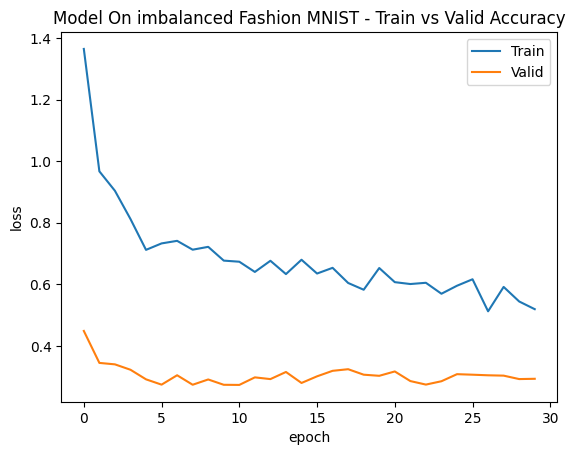

In [34]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Model On imbalanced Fashion MNIST - Train vs Valid Accuracy')

plt.show()

In [35]:
print("On Imbalanced Fashion MNIST dataset")
test_acc5, class_percentages5 = test(imbalanced_model_remix, "imbalanced_model_remix.pth")
print("Remix test accuracy : ", str(test_acc5))

On Imbalanced Fashion MNIST dataset

Test dataset: Overall Loss: 0.0010, Overall Accuracy: 8550/10000 (86%)

Remix test accuracy :  85.5


# comparison

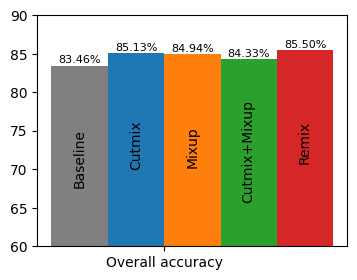

In [36]:
fig= plt.subplots(figsize=(4, 3))

br1 = np.arange(1)
br2 = [x + 0.1 for x in br1]
br3 = [x + 0.1 for x in br2]
br4 = [x + 0.1 for x in br3]
br5 = [x + 0.1 for x in br4]

p1 = plt.bar(br1, np.array(test_acc1).astype(float), width = 0.1, label ='Baseline model', color='gray')
p2 = plt.bar(br2, np.array(test_acc2).astype(float), width = 0.1, label ='cutmix model')
p3 = plt.bar(br3, np.array(test_acc3).astype(float), width = 0.1, label ='mixup model')
p4 = plt.bar(br4, np.array(test_acc4).astype(float), width = 0.1, label ='cutmix + mixup model')
p5 = plt.bar(br5, np.array(test_acc5).astype(float), width = 0.1, label ='remix model')

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=8)
    plt.text((rect1.get_x() + rect1.get_width()/2), height-12, 'Baseline', ha='center', va='center', rotation=90)
for rect1 in p2:
    height = rect1.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=8)
    plt.text((rect1.get_x() + rect1.get_width()/2), height-12, 'Cutmix', ha='center', va='center', rotation=90)
for rect1 in p3:
    height = rect1.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=8)
    plt.text((rect1.get_x() + rect1.get_width()/2), height-12, 'Mixup', ha='center', va='center', rotation=90)
for rect1 in p4:
    height = rect1.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=8)
    plt.text((rect1.get_x() + rect1.get_width()/2), height-12, 'Cutmix+Mixup', ha='center', va='center', rotation=90)
for rect1 in p5:
    height = rect1.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=8)
    plt.text((rect1.get_x() + rect1.get_width()/2), height-12, 'Remix', ha='center', va='center', rotation=90)


plt.xticks([r + 0.15 for r in range(1)], ['Overall accuracy'])
plt.ylim(60, 90)
plt.show()

In [37]:
df=pd.DataFrame({'Baseline':class_percentages1, 'Cutmix':class_percentages2, \
                 'Mixup': class_percentages3, 'Cutmix+Mixup': class_percentages4, 'Remix': class_percentages5})

df

,Baseline,Cutmix,Mixup,Cutmix+Mixup,Remix
0,0.904762,0.839286,0.904762,0.960784,0.877193
1,0.958333,0.976744,1.000000,0.979592,0.981818
2,0.755556,0.837209,0.836066,0.744681,0.851852
3,0.777778,0.745098,0.761905,0.836735,0.680000
4,0.900000,0.800000,0.888889,0.925000,0.837209
5,0.977273,0.984375,0.962264,0.936170,0.976190
6,0.370370,0.444444,0.425000,0.278689,0.470588
7,0.978723,0.937500,0.868421,0.826923,0.930233
8,0.978261,0.969697,0.942308,0.963636,0.983051
9,1.000000,1.000000,1.000000,0.959184,0.978261


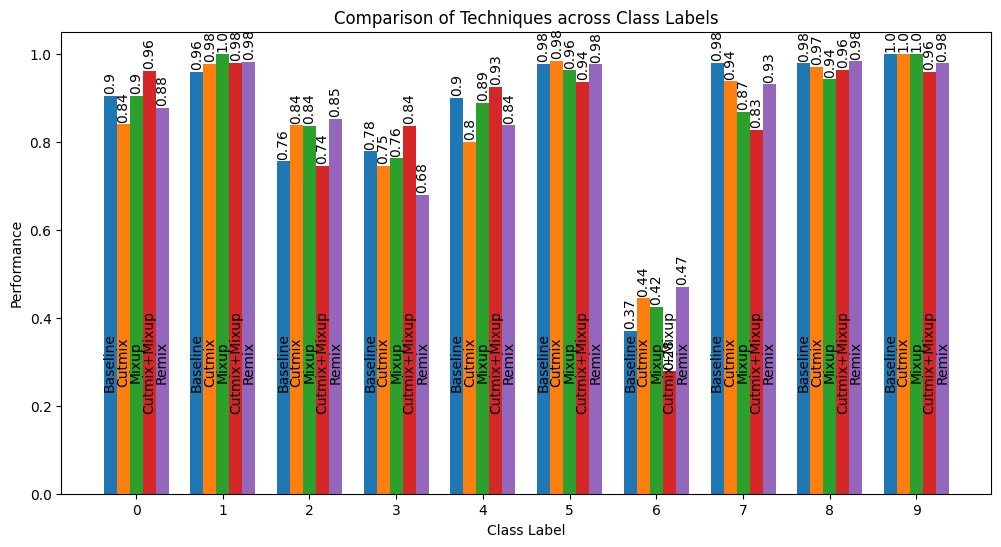

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Set the width of the bars
bar_width = 0.15

# Set the positions of the bars
r1 = np.arange(len(df['Baseline']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]

plt.figure(figsize=(12, 6))

# Create the bars
bars1 = plt.bar(r1, df['Baseline'], width=bar_width)
bars2 = plt.bar(r2, df['Cutmix'], width=bar_width)
bars3 = plt.bar(r3, df['Mixup'], width=bar_width)
bars4 = plt.bar(r4, df['Cutmix+Mixup'], width=bar_width)
bars5 = plt.bar(r5, df['Remix'], width=bar_width)

# Function to add technique labels at the bottom of the bars
def add_technique_labels(bars, positions, label):
    for bar, pos in zip(bars, positions):
        plt.text(pos, 0.3, label, ha='center', va='center', rotation=90)
        height = bar.get_height()
        plt.text(pos, height+ 0.005, f'{height:.2}', ha='center', va='bottom', rotation=90)

# Add technique labels
add_technique_labels(bars1, r1, 'Baseline')
add_technique_labels(bars2, r2, 'Cutmix')
add_technique_labels(bars3, r3, 'Mixup')
add_technique_labels(bars4, r4, 'Cutmix+Mixup')
add_technique_labels(bars5, r5, 'Remix')

# Add labels and title
plt.xlabel('Class Label')
plt.ylabel('Performance')
plt.title('Comparison of Techniques across Class Labels')
plt.xticks([r + bar_width * 2 for r in range(len(df['Baseline']))], df.index)

plt.show()
